In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
%run ImageDataLoader.ipynb
%run ImageProcessor.ipynb
%run DataExplorer.ipynb
%run DatasetStatistics.ipynb
%run DuplicateDetector.ipynb
%run OversampledDataset.ipynb
%run BatchVisualizer.ipynb
%run VGG16Model.ipynb
%run ResNet34Model.ipynb
%run EfficientNetModel.ipynb
%run Trainer.ipynb

In [5]:
DATA_ROOT = "./data"
TRAIN_DIR = "./data/Training"
TEST_DIR = "./data/Testing"
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.15

In [6]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(f"Accelerator name: {torch.cuda.get_device_name(device)}")

Using cuda device
Accelerator name: NVIDIA GeForce RTX 5070 Ti


In [7]:
loader = ImageDataLoader(TRAIN_DIR, TEST_DIR)
all_files = loader.load_all_images()

print(f"Successfully loaded {len(all_files)} images")

Successfully loaded 3027 images


In [ ]:
duplicate_detector = DuplicateDetector(all_files)
duplicate_detector.detect_duplicates()

if len(duplicate_detector.duplicates) > 0:  # If duplicate files are present
    duplicate_detector.remove_duplicates_from_disk()  # Removing duplicates entirely from disk
    all_files = duplicate_detector.get_unique_files()  # Cleaning list with file paths

In [ ]:
loader.print_dataset_class_count()

Loading 3027 images and converting to grayscale...
  Progress: 1/3027 images
  Progress: 500/3027 images
  Progress: 1000/3027 images
  Progress: 1500/3027 images
  Progress: 2000/3027 images
  Progress: 2500/3027 images
  Progress: 3000/3027 images
Images loaded


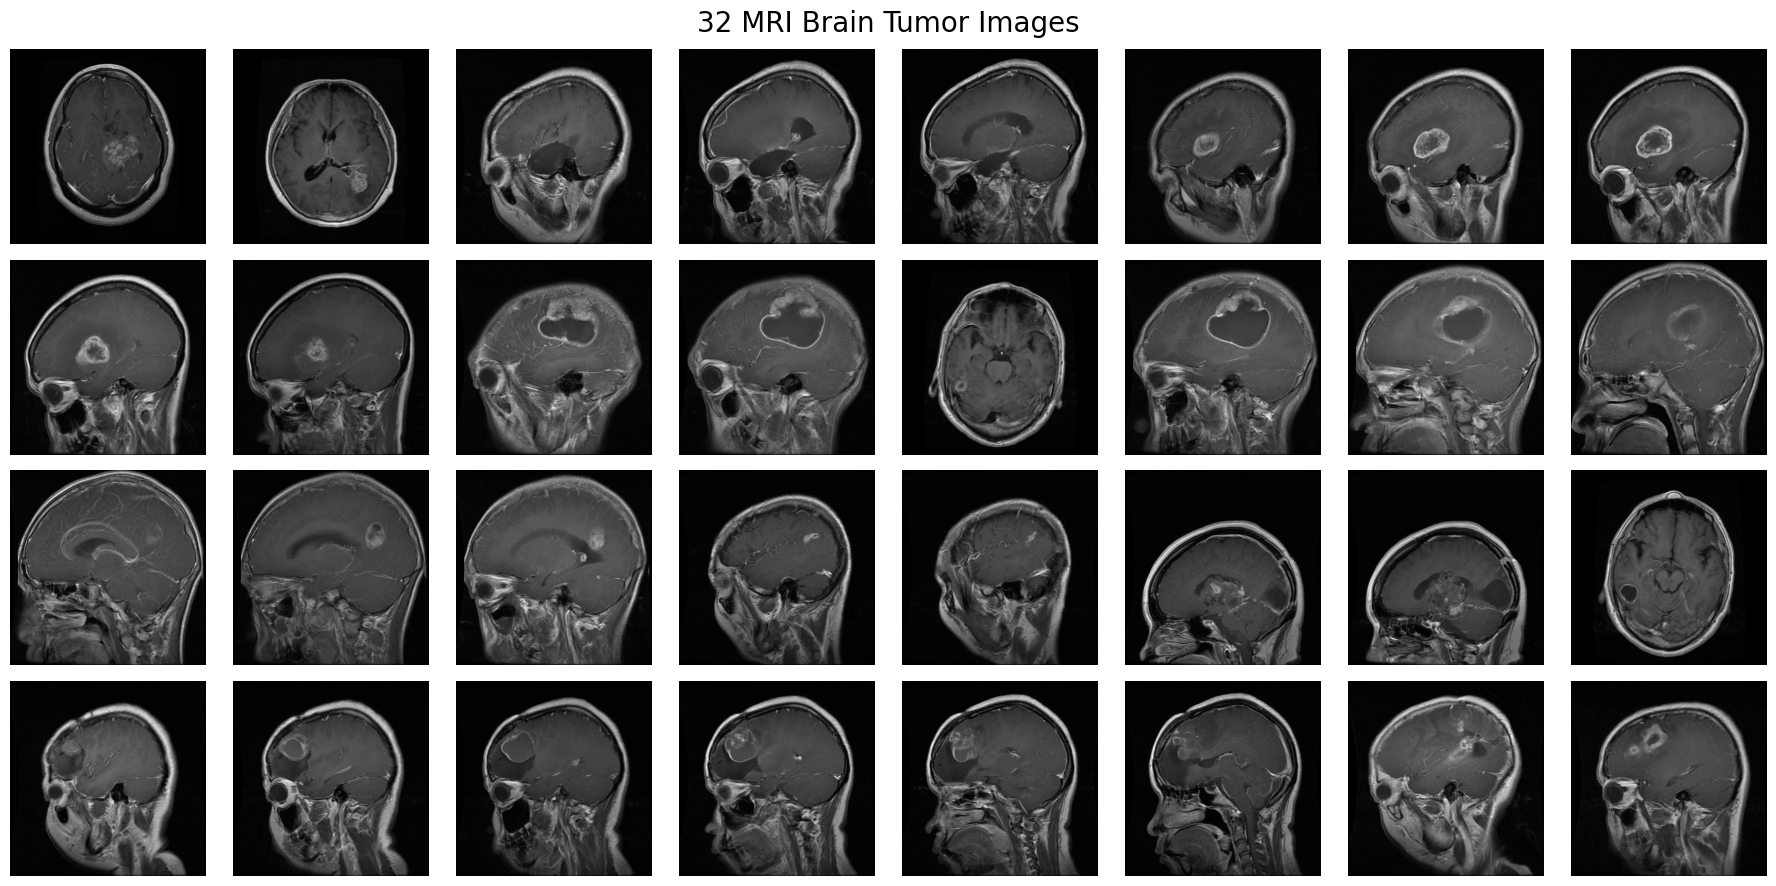

In [10]:
processor = ImageProcessor(all_files)

processor.load_grayscale_images()
processor.display_image_grid(batch_size=32, figsize=(18, 9), images_per_row=8)

In [ ]:
explorator = DataExplorer(all_files)
explorator.retrieve_sample_of_images(
    [0, len(all_files) // 2, -1]
)  # First, middle and last image

explorator.plot_histogram()

In [11]:
stats = DatasetStatistics(processor.gray_images)

stats.compute_stats()
stats.print_stats()

MEAN, STD = stats.get_normalized_values()

Dataset Statistics:
	Mean: 47.12
	Standard Deviation: 47.42
	Minimum: 0.00
	Maximum: 255.00
	Median: 35.00


In [12]:
train_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [13]:
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [14]:
trainset = OversampledDataset(TRAIN_DIR, transform=train_transform)
testset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

print()
trainset.print_class_distribution()

print()
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {trainset.classes}")

Before oversampling: 2777
After oversampling: 3112

Class distribution after oversampling:
  glioma_tumor: 818 images
  meningioma_tumor: 814 images
  no_tumor: 670 images
  pituitary_tumor: 810 images

Training samples: 3112
Test samples: 250
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [15]:
train_size = int((1 - VAL_SPLIT) * len(trainset))
val_size = len(trainset) - train_size

print(
    f"Validation set size: {val_size} images\n \
      Train set size: {train_size} images"
)

Validation set size: 467 images
       Train set size: 2645 images


In [16]:
trainset, valset = random_split(
    trainset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(trainset)}, Validation: {len(valset)}")

Train: 2645, Validation: 467


In [17]:
train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=0)

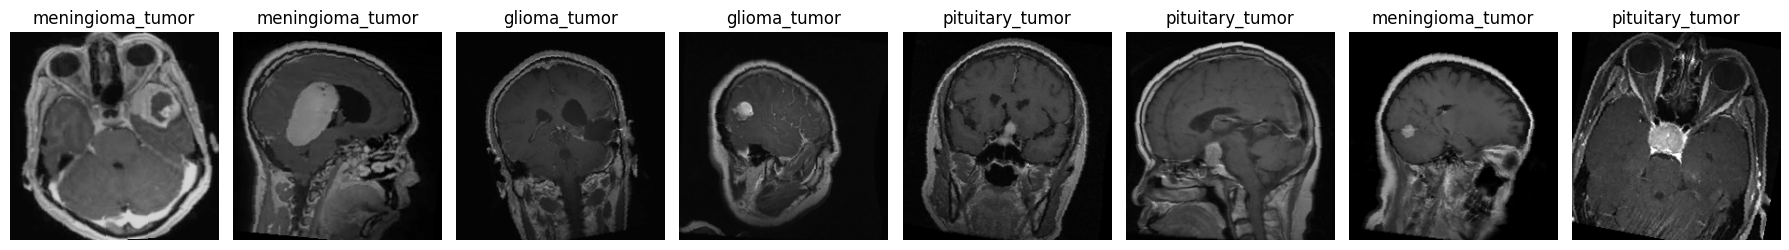

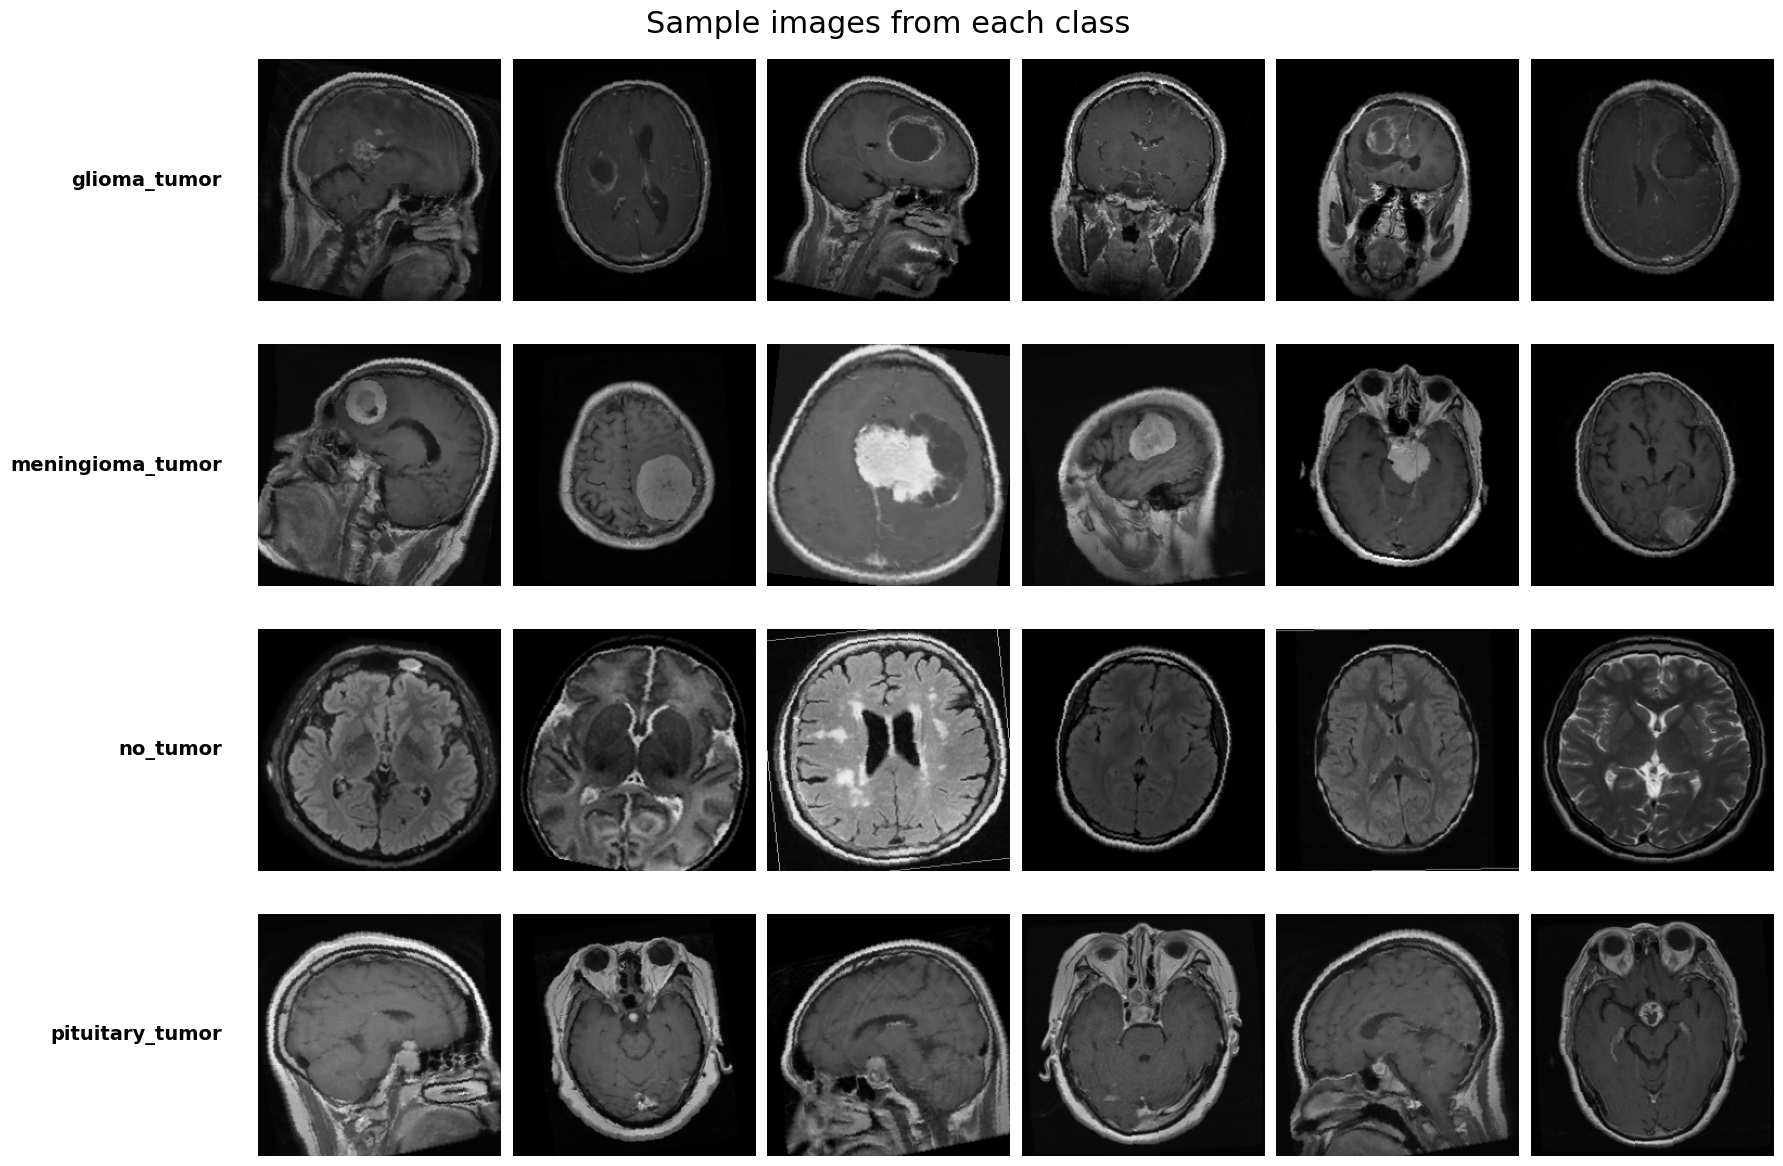

In [18]:
visualizer = BatchVisualizer(trainset.dataset.classes, mean=[MEAN] * 3, std=[STD] * 3)

visualizer.visualize_batch(train_dl)
visualizer.visualize_classes(val_dl, 6)

In [19]:
EPOCHS = 5
LEARNING_RATES = [0.01, 0.001, 0.0001, 0.00001]
NUMBER_OF_CLASSES = 4

In [38]:
models_config = {
    "VGG-16": VGG16Model,
    "ResNet34": ResNet34Model,
    "EfficientNet_B0": EfficientNetModel,
}

In [39]:
optimizers_config = {
    "sgd": lambda params, lr: optim.SGD(params, lr=lr),
    "sgd_momentum": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    "adam": lambda params, lr: optim.Adam(params, lr=lr),
}

In [22]:
def set_seed(seed=42):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (used)
    torch.cuda.manual_seed_all(seed)  # PyTorch all GPUs
    torch.backends.cudnn.deterministic = True  # CUDA deterministic operations
    torch.backends.cudnn.benchmark = False  # Turn off autotuning for reproducity

In [22]:
def run_experiment(
    model_class, optimizer_fn, lr, train_dl, val_dl, device, epochs=EPOCHS
):
    set_seed(42)

    model = model_class(NUMBER_OF_CLASSES)
    trainer = Trainer(model, device)
    optimizer = optimizer_fn(model.parameters(), lr)

    history = trainer.fit(train_dl, val_dl, optimizer, epochs)

    return {
        "last_epoch_val_acc": history["val_acc"][-1],
        "best_val_acc": max(history["val_acc"]),
        "last_epoch_val_loss": history["val_loss"][-1],
        "history": history,
    }

In [ ]:
def run_all_experiments(train_dl, val_dl, device):
    res = []

    total = len(models_config) * len(optimizers_config) * len(LEARNING_RATES)
    current = 0

    for model_name, model_class in models_config.items():
        for optim_name, optim_fn in optimizers_config.items():
            for lr in LEARNING_RATES:
                current += 1
                print(f"\n[{current}/{total}] {model_name} + {optim_name} + lr={lr}")

                result = run_experiment(
                    model_class, optim_fn, lr, train_dl, val_dl, device
                )

                res.append(
                    {
                        "model": model_name,
                        "optimizer": optim_name,
                        "learning rate": lr,
                        **result,
                    }
                )
                print(
                    f"Last epoch's validation accuracy: {result['last_epoch_val_acc']:.4f}"
                )

    return res

In [ ]:
results = run_all_experiments(train_dl, val_dl, device)

In [24]:
FINAL_EPOCHS = 50
PATIENCE = 10

In [ ]:
set_seed(42)

vgg16_model = VGG16Model()
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.0001)

trainer_vgg16 = Trainer(vgg16_model, device)
vgg16_history = trainer_vgg16.fit(
    train_dl, val_dl, optimizer_vgg16, FINAL_EPOCHS, PATIENCE
)
vgg16_acc, vgg16_preds, vgg16_labels = trainer_vgg16.test(test_dl)

Epoch 1 out of 50 epochs.                   	Train loss: 0.6541, train accuracy: 0.7319                   	Validation loss: 0.4368, validation accuracy: 0.8394
Epoch 2 out of 50 epochs.                   	Train loss: 0.2697, train accuracy: 0.9017                   	Validation loss: 0.2638, validation accuracy: 0.9122
Epoch 3 out of 50 epochs.                   	Train loss: 0.1454, train accuracy: 0.9535                   	Validation loss: 0.2331, validation accuracy: 0.9229
Epoch 4 out of 50 epochs.                   	Train loss: 0.1131, train accuracy: 0.9611                   	Validation loss: 0.1944, validation accuracy: 0.9486
Epoch 5 out of 50 epochs.                   	Train loss: 0.0838, train accuracy: 0.9713                   	Validation loss: 0.1614, validation accuracy: 0.9443
Epoch 6 out of 50 epochs.                   	Train loss: 0.0614, train accuracy: 0.9781                   	Validation loss: 0.1789, validation accuracy: 0.9336
Epoch 7 out of 50 epochs.               

In [64]:
set_seed(42)

resnet34_model = ResNet34Model()
optimizer_resnet = optim.SGD(resnet34_model.parameters(), lr=0.001, momentum=0.9)

trainer_resnet34 = Trainer(resnet34_model, device)
resnet34_history = trainer_resnet34.fit(
    train_dl, val_dl, optimizer_resnet, FINAL_EPOCHS, PATIENCE
)
resnet34_acc, resnet34_preds, resnet34_labels = trainer_resnet34.test(test_dl)

Epoch 1 out of 50 epochs.                   	Train loss: 0.9015, train accuracy: 0.6526                   	Validation loss: 0.5277, validation accuracy: 0.8266
Epoch 2 out of 50 epochs.                   	Train loss: 0.3590, train accuracy: 0.8737                   	Validation loss: 0.3586, validation accuracy: 0.8822
Epoch 3 out of 50 epochs.                   	Train loss: 0.2350, train accuracy: 0.9191                   	Validation loss: 0.2610, validation accuracy: 0.8994
Epoch 4 out of 50 epochs.                   	Train loss: 0.1583, train accuracy: 0.9463                   	Validation loss: 0.2308, validation accuracy: 0.9143
Epoch 5 out of 50 epochs.                   	Train loss: 0.1197, train accuracy: 0.9645                   	Validation loss: 0.1952, validation accuracy: 0.9293
Epoch 6 out of 50 epochs.                   	Train loss: 0.0975, train accuracy: 0.9679                   	Validation loss: 0.1859, validation accuracy: 0.9272
Epoch 7 out of 50 epochs.               

In [ ]:
set_seed(42)

efficientnet_model = EfficientNetModel()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)

trainer_efficientnet = Trainer(efficientnet_model, device)
efficientnet_history = trainer_efficientnet.fit(
    train_dl, val_dl, optimizer_efficientnet, FINAL_EPOCHS, PATIENCE
)
efficientnet_acc, efficientnet_preds, efficientnet_labels = trainer_efficientnet.test(
    test_dl
)

In [94]:
print(vgg16_acc, resnet34_acc)

0.688 0.716


In [92]:
def plot_train_val_accuracy(train_acc, val_acc, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_acc, "r--", label="Training accuracy")
    ax.plot(val_acc, "b-", label="Validation accuracy")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    if title is not None:
        ax.set_title(title, fontsize=10)

    ax.grid()
    ax.legend()

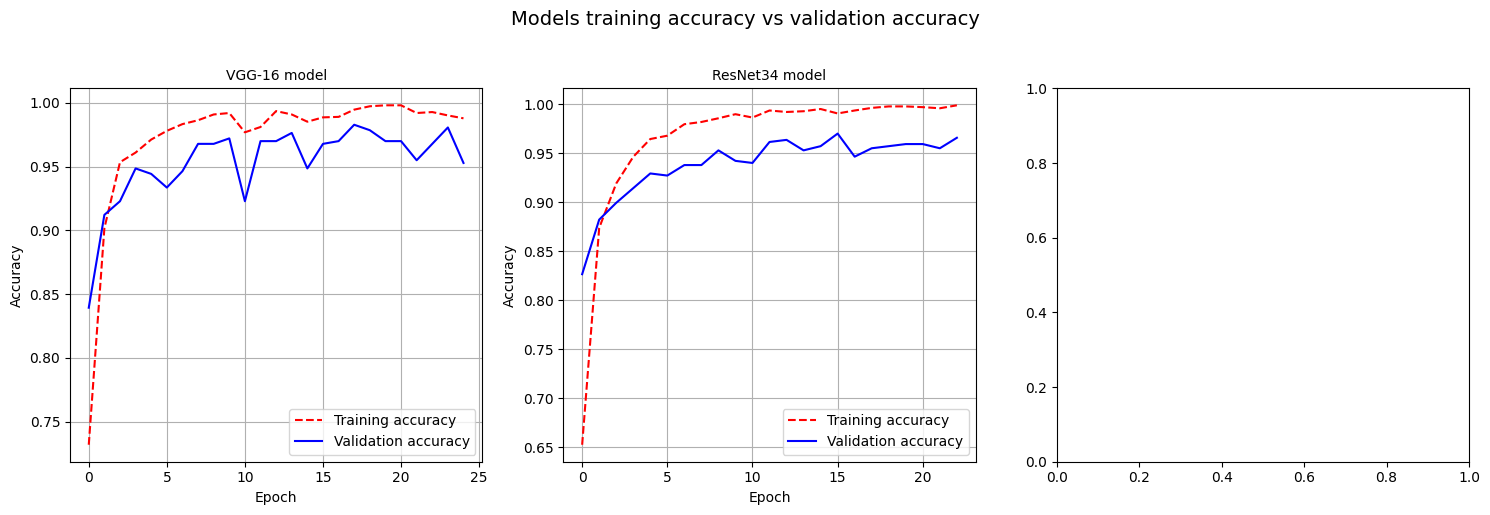

In [93]:
_, axs = plt.subplots(ncols=3, figsize=(15, 5))
plot_train_val_accuracy(
    vgg16_history["train_acc"], vgg16_history["val_acc"], "VGG-16 model", axs[0]
)

plot_train_val_accuracy(
    resnet34_history["train_acc"], resnet34_history["val_acc"], "ResNet34 model", axs[1]
)

plt.suptitle("Models training accuracy vs validation accuracy", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [95]:
# Sprawdź accuracy na train_dl - jeśli model działa, powinno być ~99%
train_acc, _, _ = trainer_vgg16.test(train_dl)
print(f"Train acc (przez test method): {train_acc:.4f}")

# Sprawdź czy klasy są zgodne
print(f"Train classes: {trainset.dataset.classes}")
print(f"Test classes: {testset.classes}")

Train acc (przez test method): 0.9868
Train classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Test classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
